In [1]:
from imports import *
from exactDiagMethods import perform_exact_diag, build_exact_diag_hamiltonian
from globalMethods import build_initial_states, output_results
from vqteMethods import  hamiltonian_generation, perform_vqte


In [ ]:

def main():

    # Initialize the simulation parameters
    gamma_L = 1
    gamma_R = 1

    eps = 1.0

    mu_L= 1.0
    mu_R= 1.0

    # Temperature of Reserviors
    T_L = 1.0
    T_R= 1.0

    time = 5
    dt = 0.01
    nt = int(time/dt)

    beta_L=1/T_L
    beta_R=1/T_R
    F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
    F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)


    # Generate Hamiltonians
    exact_diag_ham = build_exact_diag_hamiltonian(eps)
    ham_real, ham_imag = hamiltonian_generation(eps, gamma_L, gamma_R, F_R,F_L)
    print("Exact Diag Ham: ", exact_diag_ham)
    print("Ham real: ", ham_real)
    print("Ham imag: ", ham_imag)


    # Generate initial states
    vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real)
    print("Initil State : " , vqte_init_state)
    print("Exact Initial : ", exact_diag_init_state)

    # Perform exact diagonalization
    exact_diag_results, time_points = perform_exact_diag(gamma_L, F_L, gamma_R, F_R, dt, nt, exact_diag_init_state, exact_diag_ham)

    # Perform vqte simulation
    vqte_results = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values)

    #Output results
    output_results(vqte_results, exact_diag_results, time, nt, time_points)
    print(vqte_results[-1])


Exact Diag Ham:  [[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
Ham real:  SparsePauliOp(['IZ', 'ZI', 'XY', 'YX'],
              coeffs=[-0.5+0.j,  0.5+0.j, -0. +0.j, -0. +0.j])
Ham imag:  SparsePauliOp(['XX', 'YY', 'II', 'IZ', 'ZI'],
              coeffs=[-0.5+0.j,  0.5+0.j,  1. +0.j, -0. +0.j, -0. +0.j])
Initil State :  Statevector([ 1.0000000e+00+4.89858720e-16j,
             -1.2246468e-16-2.99951957e-32j,
             -2.4492936e-16-2.99951957e-32j,
             -1.2246468e-16+2.99951957e-32j],
            dims=(2, 2))
Exact Initial :  [[ 1.0000000e+00+4.89858720e-16j -2.4492936e-16-2.99951957e-32j]
 [-1.2246468e-16-2.99951957e-32j -1.2246468e-16+2.99951957e-32j]]
Is Hermitian: True
Trace: (0.9999999999999999+4.898587196589413e-16j) (should be 1)
Eigenvalues: [-1.2246468e-16  1.0000000e+00]
All eigenvalues ≥ 0: False
Purity (Tr(ρ²)): (1+9.797174393178826e-16j) (should be 1 for pure state)
Initial expectation value of number operator: (-1.224646799147353e-16+8.998558695971146e-32j)
Step 0 out 

C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


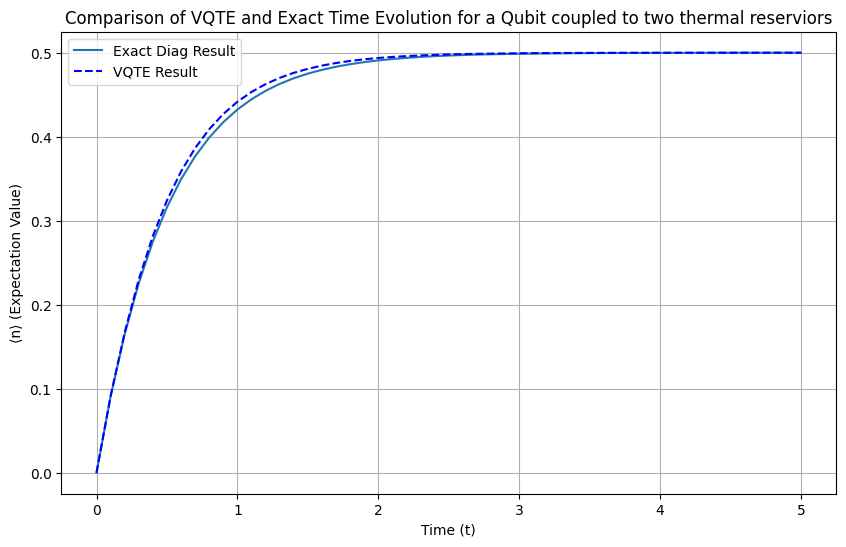

0.4999922250610358


In [3]:
main()